## Features+Head Ensemble Starter [LB 0.34] for HMS Brain Comp
We can train 9 model and data variations: (all models included)

**The Ensemble achieves LB 0.34**

| MODEL | DATA TYPE | CV | LB |TRAINING TIME| NOTES |
|----------------|-----------|----------|---|--|--|
| EfficientNetB2 | K | 0.6123 | 0.41 | 2 hours and 58 minutes |K: Kaggle's spectrograms|
| EfficientNetB2 | E | 0.6288 | 0.39 | 2 hours and 57 minutes |E: EEG's spectrograms|
| WaveNet | R | 0.6992 | 0.41 | 3 hours and 35 minutes |R: Raw EEG signals|
| EfficientNetB2 | KE | 0.5646 | 0.37 | 3 hours |KE: Kaggle's and EEG's spectrograms|
| EfficientNetB2 + WaveNet | KR | 0.5912 | 0.39 | 4 hours and 20 minutes |KR: Kaggle's spectrograms and Raw EEG signals|
| EfficientNetB2 + WaveNet | ER | 0.6085 | 0.38 | 4 hours and 22 minutes |ER: EEG's spectrograms and Raw EEG signals|
| EfficientNetB2 + WaveNet | KER | - | 0.36 | 4 hours and 30 minutes |KER: Kaggle's, EEG's spectrograms and Raw EEG signals|
| EfficientNetB2 | K+E | 0.5738 | 0.37 | 5 hours and 42 minutes |K+E: Data spectrogram augmentation|
| EfficientNetB2 | K+E+KE | | 0.36 | 8 hours and 42 minutes |K+E+KE: Data spectrogram augmentation|

Great discussion [here][5] by @KOLOO that led to the latest scores!

Features+Head Starter uses Chris Deotte's Kaggle dataset [here][1]. Also Uses Chris's EEG spectrograms [here][3] (modified version). The Raw EEG signals can be found [here][6]. This notebook is a direct descendent of Chris's notebooks [EfficientNet][2] and [WaveNet][4]

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms
[2]: https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57
[3]: https://www.kaggle.com/datasets/nartaa/eeg-spectrograms
[4]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468684
[5]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/477461
[6]: https://www.kaggle.com/datasets/nartaa/hms-eeg

In [23]:
import librosa
import os, random
import tensorflow
import tensorflow as tf
import albumentations as albu
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from scipy.signal import butter, lfilter
import tensorflow.keras.backend as K, gc
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold, GroupKFold

LOAD_BACKBONE_FROM = '/kaggle/input/efficientnetb-tf-keras/EfficientNetB2.h5'
LOAD_MODELS_FROM = None
HMS_PATH = '/kaggle/input/hms-harmful-brain-activity-classification'

MODEL = {'K+E+KE': 52} # Setup the model for Training
for DATA_TYPE in MODEL: pass # K|E|R|KE|KR|ER|KER|K+E|K+E+KE

# https://www.kaggle.com/code/nartaa/hms-eeg-signal-processing
USE_PROCESSED = True # Use processed downsampled Raw EEG
TEST_MODE = False # USE 500 samples for quick testing
TEST_ENSEMBLE = False # Local Ensemble CV Testing
SUBMISSION = False

# Setup for ensemble
ENSEMBLE = True
MODELS = {
          'K'     : 43, # 'LB':0.41 Kaggle's spectrogram model version
          'E'     : 42, # 'LB':0.39 EEG's spectrogram model version
          'R'     : 37, # 'LB':0.41 EEG's Raw wavenet model version, trained on single GPU
          'KE'    : 47, # 'LB':0.37 Kaggle's and EEG's spectrogram model version
          'KR'    : 48, # 'LB':0.39 Kaggle's spectrogram and Raw model version
          'ER'    : 49, # 'LB':0.38 EEG's spectrogram and Raw model version
          'KER'   : 50, # 'LB':0.36 EEG's, Kaggle's spectrograms and Raw model version
          'K+E'   : 51, # 'LB':0.37 Data spectrogram augmentation model version
          'K+E+KE': 52, # 'LB':0.36 Data spectrogram augmentation model version
         }

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# USE SINGLE GPU, MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
# WE USE MIXED PRECISION
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
if len(gpus)>1:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')

Using 1 GPU


In [7]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS2,range(len(FEATS2)))}
META = ['spectrogram_id','spectrogram_label_offset_seconds','patient_id','expert_consensus']

### Load and create Non-Overlapping Eeg Id Train Data

The competition data description says that test data does not have multiple crops from the same `eeg_id`. Therefore we will train and validate using only 1 crop per `eeg_id`. There is a discussion about this [here][1].

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [11]:
def eeg_from_parquet(parquet_path):

    eeg = pd.read_parquet(parquet_path, columns=FEATS2)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    data = np.zeros((10_000,len(FEATS2)))
    for j,col in enumerate(FEATS2):

        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0

        data[:,j] = x

    return data

def add_kl(data):
    labels = data[TARGETS].values + 1e-5
    data['kl'] = tf.keras.losses.KLDivergence(reduction='none')(
        np.array([[1/6]*6]*len(data)),labels)
    return data

if not SUBMISSION:
    train = pd.read_csv(f'{HMS_PATH}/train.csv')
    train = train.groupby('eeg_id')[META+TARGETS].agg({**{m:'first' for m in META},**{t:'sum' for t in TARGETS}}).reset_index()
    train[TARGETS] = train[TARGETS]/train[TARGETS].values.sum(axis=1,keepdims=True)
    train.columns = ['eeg_id','spec_id','offset','patient_id','target'] + TARGETS
    train = add_kl(train)

    print(train.head(1).to_string())

   eeg_id    spec_id  offset  patient_id target  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote        kl
0  568657  789577333     0.0       20654  Other           0.0       0.0      0.25        0.0   0.166667    0.583333  4.584192


### Read Train Spectrograms and EEGs

We can read 3 file from Chris's [Kaggle dataset here][1] which contains all the 11k spectrograms. From Chris's modified EEG spectrogram [here][2]. From Raw EEG signals [here][3]

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms
[2]: https://www.kaggle.com/datasets/nartaa/eeg-spectrograms
[3]: https://www.kaggle.com/datasets/nartaa/hms-eeg

In [15]:
%%time
if not SUBMISSION:
    # FOR TESTING SET TEST_MODE TO TRUE
    if TEST_MODE:
        USE_PROCESSED = False
        train = train.sample(500,random_state=42).reset_index(drop=True)
        spectrograms = {}
        for i,e in enumerate(train.spec_id.values):
            if i%100==0: print(i,', ',end='')
            x = pd.read_parquet(f'{HMS_PATH}/train_spectrograms/{e}.parquet')
            spectrograms[e] = x.values

        all_eegs = {}
        for i,e in enumerate(train.eeg_id.values):
            if i%100==0: print(i,', ',end='')
            x = np.load(f'/kaggle/input/hms-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
            all_eegs[e] = x

        all_raw_eegs = {}
        for i,e in enumerate(train.eeg_id.values):
            if i%100==0: print(i,', ',end='')
            x = eeg_from_parquet(f'{HMS_PATH}/train_eegs/{e}.parquet')
            all_raw_eegs[e] = x
    else:
        spectrograms = None
        all_eegs = None
        all_raw_eegs = None
        if TEST_ENSEMBLE or DATA_TYPE in ['K','KE','K+E','K+E+KE','KR','KER']:
            spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()
        if TEST_ENSEMBLE or DATA_TYPE in ['E','KE','K+E','K+E+KE','ER','KER']:
            all_eegs = np.load('/kaggle/input/hms-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()
        if TEST_ENSEMBLE or DATA_TYPE in ['R','KR','ER','KER']:
            if USE_PROCESSED:
                all_raw_eegs = np.load('/kaggle/input/hms-eeg/eegs_processed.npy',allow_pickle=True).item()
            else:
                all_raw_eegs = np.load('/kaggle/input/hms-eeg/eegs.npy',allow_pickle=True).item()

CPU times: user 78.4 ms, sys: 3.99 s, total: 4.07 s
Wall time: 5.7 s


### DATA GENERATOR
This data generator outputs 512x512x3, the spectrogram and eeg images are concatenated all togother in a single image. For using data augmention you can set `augment = True` when creating the train data generator.

In [16]:
class DataGenerator():
    'Generates data for Keras'
    def __init__(self, data, specs=None, eeg_specs=None, raw_eegs=None , augment=False, mode='train', data_type=DATA_TYPE):
        self.augment = augment
        self.mode = mode
        self.data_type = data_type
        self.data = self.build_data(data)
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.raw_eegs = raw_eegs
        self.on_epoch_end()

    def build_data(self,data):
        if self.data_type in ['K+E']:
            data_dup = pd.concat([data] * 2, ignore_index=True)
            data_dup.loc[:len(data),'data_type'] = 'K'
            data_dup.loc[len(data):,'data_type'] = 'E'
            data = data_dup
        elif self.data_type in ['K+E+KE']:
            data_trp = pd.concat([data] * 3, ignore_index=True)
            data_trp.loc[:len(data),'data_type'] = 'K'
            data_trp.loc[len(data):len(data)*2,'data_type'] = 'E'
            data_trp.loc[len(data)*2:,'data_type'] = 'KE'
            data = data_trp
        else:
            data['data_type'] = self.data_type
        return data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        X, y = self.data_generation(index)
        if self.augment: X = self.augmentation(X)
        return X, y

    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

            if i == self.__len__()-1:
                self.on_epoch_end()

    def on_epoch_end(self):
        if self.mode=='train':
            self.data = self.data.sample(frac=1).reset_index(drop=True)

    def data_generation(self, index):
        row = self.data.iloc[index]
        if row.data_type == 'KE':
            X,y = self.generate_all_specs(index)
        elif row.data_type in ['K','E']:
            X,y = self.generate_specs(index)
        elif row.data_type == 'R':
            X,y = self.generate_raw(index)
        elif row.data_type in ['ER','KR']:
            X1,y = self.generate_specs(index)
            X2,y = self.generate_raw(index)
            X = (X1,X2)
        elif row.data_type in ['KER']:
            X1,y = self.generate_all_specs(index)
            X2,y = self.generate_raw(index)
            X = (X1,X2)
        return X,y

    def generate_all_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')

        row = self.data.iloc[index]
        if self.mode=='test':
            offset = 0
        else:
            offset = int(row.offset/2)

        eeg = self.eeg_specs[row.eeg_id]
        spec = self.specs[row.spec_id]

        imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
        img = np.stack(imgs,axis=-1)
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img,np.exp(-4),np.exp(8))
        img = np.log(img)

        # STANDARDIZE PER IMAGE
        img = np.nan_to_num(img, nan=0.0)

        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)

        X[0_0+56:100+56,:256,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,:256,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,:256,1] = img[:,22:-22,3] # RP_k
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2] # RL_k
        X[100+56:200+56,:256,2] = img[:,22:-22,1] # LP_k

        X[0_0+56:100+56,256:,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,256:,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,256:,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,256:,1] = img[:,22:-22,3] # RP_K

        # EEG
        img = eeg
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        X[200+56:300+56,:256,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,:256,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,:256,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,:256,1] = img[:,22:-22,3] # RP_e
        X[200+56:300+56,:256,2] = img[:,22:-22,2] # RL_e
        X[300+56:400+56,:256,2] = img[:,22:-22,1] # LP_e

        X[200+56:300+56,256:,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,256:,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,256:,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,256:,1] = img[:,22:-22,3] # RP_e

        if self.mode!='test':
            y[:] = row[TARGETS]

        return X,y

    def generate_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')

        row = self.data.iloc[index]
        if self.mode=='test':
            offset = 0
        else:
            offset = int(row.offset/2)

        if row.data_type in ['E','ER']:
            img = self.eeg_specs[row.eeg_id]
        elif row.data_type in ['K','KR']:
            spec = self.specs[row.spec_id]
            imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
            img = np.stack(imgs,axis=-1)
            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img,np.exp(-4),np.exp(8))
            img = np.log(img)

            # STANDARDIZE PER IMAGE
            img = np.nan_to_num(img, nan=0.0)

        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)

        X[0_0+56:100+56,:256,0] = img[:,22:-22,0]
        X[100+56:200+56,:256,0] = img[:,22:-22,2]
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1]
        X[100+56:200+56,:256,1] = img[:,22:-22,3]
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2]
        X[100+56:200+56,:256,2] = img[:,22:-22,1]

        X[0_0+56:100+56,256:,0] = img[:,22:-22,0]
        X[100+56:200+56,256:,0] = img[:,22:-22,1]
        X[0_0+56:100+56,256:,1] = img[:,22:-22,2]
        X[100+56:200+56,256:,1] = img[:,22:-22,3]

        X[200+56:300+56,:256,0] = img[:,22:-22,0]
        X[300+56:400+56,:256,0] = img[:,22:-22,1]
        X[200+56:300+56,:256,1] = img[:,22:-22,2]
        X[300+56:400+56,:256,1] = img[:,22:-22,3]
        X[200+56:300+56,:256,2] = img[:,22:-22,3]
        X[300+56:400+56,:256,2] = img[:,22:-22,2]

        X[200+56:300+56,256:,0] = img[:,22:-22,0]
        X[300+56:400+56,256:,0] = img[:,22:-22,2]
        X[200+56:300+56,256:,1] = img[:,22:-22,1]
        X[300+56:400+56,256:,1] = img[:,22:-22,3]

        if self.mode!='test':
            y[:] = row[TARGETS]

        return X,y

    def generate_raw(self,index):
        if USE_PROCESSED and self.mode!='test':
            X = np.zeros((2_000,8),dtype='float32')
            y = np.zeros((6,),dtype='float32')
            row = self.data.iloc[index]
            X = self.raw_eegs[row.eeg_id]
            y[:] = row[TARGETS]
            return X,y

        X = np.zeros((10_000,8),dtype='float32')
        y = np.zeros((6,),dtype='float32')

        row = self.data.iloc[index]
        eeg = self.raw_eegs[row.eeg_id]

        # FEATURE ENGINEER
        X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
        X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]

        X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
        X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]

        X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
        X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]

        X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
        X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]

        # STANDARDIZE
        X = np.clip(X,-1024,1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # BUTTER LOW-PASS FILTER
        X = self.butter_lowpass_filter(X)
        # Downsample
        X = X[::5,:]

        if self.mode!='test':
            y[:] = row[TARGETS]

        return X,y

    def butter_lowpass_filter(self, data, cutoff_freq=20, sampling_rate=200, order=4):
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = lfilter(b, a, data, axis=0)
        return filtered_data

    def resize(self, img,size):
        composition = albu.Compose([
                albu.Resize(size[0],size[1])
            ])
        return composition(image=img)['image']

    def augmentation(self, img):
        composition = albu.Compose([
                albu.HorizontalFlip(p=0.4)
            ])
        return composition(image=img)['image']

def spectrogram_from_eeg(parquet_path):

    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]

    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((100,300,4),dtype='float32')

    for k in range(4):
        COLS = FEATS[k]

        for kk in range(4):
            # FILL NANS
            x1 = eeg[COLS[kk]].values
            x2 = eeg[COLS[kk+1]].values
            m = np.nanmean(x1)
            if np.isnan(x1).mean()<1: x1 = np.nan_to_num(x1,nan=m)
            else: x1[:] = 0
            m = np.nanmean(x2)
            if np.isnan(x2).mean()<1: x2 = np.nan_to_num(x2,nan=m)
            else: x2[:] = 0

            # COMPUTE PAIR DIFFERENCES
            x = x1 - x2

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//300,
                  n_fft=1024, n_mels=100, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//30)*30
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]
            img[:,:,k] += mel_spec_db

        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0

    return img

def eeg_from_parquet(parquet_path):
    eeg = pd.read_parquet(parquet_path, columns=FEATS2)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    data = np.zeros((10_000,len(FEATS2)))
    for j,col in enumerate(FEATS2):

        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0

        data[:,j] = x

    return data

### DISPLAY DATA GENERATOR
Below we display example data generator spectrogram images and raw EEG signals.

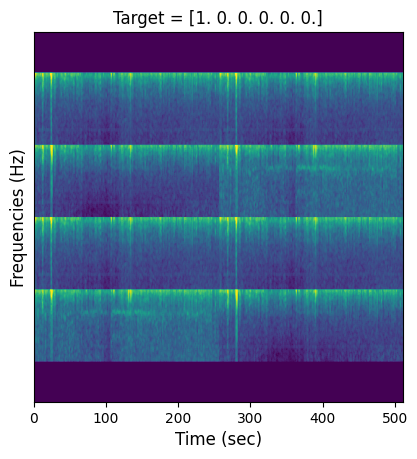

In [17]:
if not SUBMISSION:
    params = {'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
    augment=True if not SUBMISSION else False
    gen = DataGenerator(train, augment=augment, **params)
    for x,y in gen:
        break

    if DATA_TYPE in ['E','K','KE','K+E','K+E+KE','KR','ER','KER']:
        x1 = x[0] if DATA_TYPE in ['KR','ER','KER'] else x
        plt.imshow(x1[:,:,0])
        plt.title(f'Target = {y.round(1)}',size=12)
        plt.yticks([])
        plt.ylabel('Frequencies (Hz)',size=12)
        plt.xlabel('Time (sec)',size=12)

    if DATA_TYPE in ['R','KR','ER','KER']:
        x1 = x[1] if DATA_TYPE in ['KR','ER','KER'] else x
        plt.figure(figsize=(20,4))
        offset = 0
        for j in range(x1.shape[-1]):
            if j!=0: offset -= x1[:,j].min()
            plt.plot(range(2_000),x1[:,j]+offset,label=f'feature {j+1}')
            offset += x1[:,j].max()
        plt.legend()

    plt.show()

### TRAINING

#### LEARNING RATE

In [18]:

if not SUBMISSION:

    def lrfn(epoch):
        e3 = 1e-3 if DATA_TYPE in ['R'] else 1e-4
        return [1e-3,1e-3,e3,1e-4,1e-5][epoch]

    LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

    def lrfn2(epoch):
        return [1e-5,1e-5,1e-6][epoch]

    LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn2, verbose = True)

### MODEL AND UTILITY FUNCTIONS

In [19]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate, LayerNormalization


def build_model(data_type=DATA_TYPE):
    K.clear_session()
    with strategy.scope():
        if data_type in ['R']:
            model = build_wave_model()
        elif data_type in ['K','E','KE','K+E','K+E+KE']:
            model = build_spec_model()
        elif data_type in ['KR','ER','KER']:
            model = build_hybrid_model()
    return model

def build_spec_model(hybrid=False):
    inp = tf.keras.layers.Input((512,512,3))
    base_model = load_model(f'{LOAD_BACKBONE_FROM}')
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if not hybrid:
        x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)
    return model

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'tanh',
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid',
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

def build_wave_model(hybrid=False):

    # INPUT
    inp = tf.keras.Input(shape=(2_000,8))

    ############
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(2_000,1))
    x = wave_block(inp2, 8, 4, 6)
    x = wave_block(x, 16, 4, 6)
    x = wave_block(x, 32, 4, 6)
    x = wave_block(x, 64, 4, 6)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########

    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])

    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])

    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])

    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])

    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    if not hybrid:
        y = tf.keras.layers.Dense(64, activation='relu')(y)
        y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)

    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)

    return model

def build_hybrid_model():
    model_spec = build_spec_model(True)
    model_wave = build_wave_model(True)
    inputs = [model_spec.input, model_wave.input]
    x = [model_spec.output, model_wave.output]
    x = tf.keras.layers.Concatenate()(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)

    # COMPILE MODEL
    model = tf.keras.Model(inputs=inputs, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)

    return model

def score(y_true, y_pred):
    kl = tf.keras.metrics.KLDivergence()
    return kl(y_true, y_pred)

def plot_hist(hist):
    metrics = ['loss']
    for i,metric in enumerate(metrics):
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,i+1)
        plt.plot(hist[metric])
        plt.plot(hist[f'val_{metric}'])
        plt.title(f'{metric}',size=12)
        plt.ylabel(f'{metric}',size=12)
        plt.xlabel('epoch',size=12)
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()

def dataset(data, mode='train', batch_size=8, data_type=DATA_TYPE,
            augment=False, specs=None, eeg_specs=None, raw_eegs=None):

    BATCH_SIZE_PER_REPLICA = batch_size
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    gen = DataGenerator(data,mode=mode, data_type=data_type, augment=augment,
                       specs=specs, eeg_specs=eeg_specs, raw_eegs=raw_eegs)
    if data_type in ['K','E','KE','K+E','K+E+KE']:
        inp = tf.TensorSpec(shape=(512,512,3), dtype=tf.float32)
    elif data_type in ['KR','ER','KER']:
        inp = (tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),tf.TensorSpec(shape=(2000,8), dtype=tf.float32))
    elif data_type in ['R']:
        inp = tf.TensorSpec(shape=(2000,8), dtype=tf.float32)

    output_signature = (inp,tf.TensorSpec(shape=(6,), dtype=tf.float32))
    dataset = tf.data.Dataset.from_generator(generator=gen, output_signature=output_signature).batch(
        BATCH_SIZE)
    return dataset

def reset_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def get_size(x):
    if DATA_TYPE in ['K+E']:
        size = 2*len(x)
    elif  DATA_TYPE in ['K+E+KE']:
        size = 3*len(x)
    else:
        size = len(x)
    return size

def predict(models, params, fold, models_path=None):
    preds = []
    if models_path is None: models_path = LOAD_MODELS_FROM
    model_wave = build_wave_model()
    model_spec = build_spec_model()
    model_hybrid = build_hybrid_model()
    for data_type in models:
        data = params['data']
        ver = models[data_type]
        ds = dataset(data_type=data_type, **params)
        if data_type in ['R']:
            model = model_wave
        elif data_type in ['K','E','KE','K+E','K+E+KE']:
            model = model_spec
        elif data_type in ['KR','ER','KER']:
            model = model_hybrid
        model.load_weights(f'{models_path}/model_{data_type}_{ver}_{fold}.weights.h5')
        pred = model.predict(ds)
        if data_type in ['K+E']:
            pred = (pred[:len(data)] + pred[len(data):])/2
        if data_type in ['K+E+KE']:
            pred = (pred[:len(data)] + pred[len(data):len(data)*2] + pred[len(data)*2:])/3
        preds.append(pred)
    pred = np.mean(preds,axis=0)
    del model_wave, model_spec, model_hybrid
    gc.collect()
    return pred

### TRANSFER LEARNING

#########################
### Fold 1
### train size 41013, valid size 10254
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-13 23:52:23.901590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-13 23:52:23.903186: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:18"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
 

   5127/Unknown - 301s 54ms/step - loss: 0.7533

2024-03-13 23:57:24.810527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-13 23:57:24.810854: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:21"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
 

5127/5127 [==============================] - 340s 61ms/step - loss: 0.7533 - val_loss: 0.8741 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
   2/5127 [..............................] - ETA: 4:59 - loss: 0.3330

2024-03-13 23:58:03.870274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-13 23:58:03.874780: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-13 23:58:03.890243: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-13 23:58:03.892945: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-13 23:58:03.894025: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-13 23:58:03.902215: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5127/5127 [==============================] - ETA: 0s - loss: 0.5907

2024-03-14 00:02:40.920488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:02:40.925825: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:02:40.941413: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:02:40.944053: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:02:40.945143: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:02:40.947319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 317s 62ms/step - loss: 0.5907 - val_loss: 0.8163 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
   2/5127 [..............................] - ETA: 4:19 - loss: 0.6301

2024-03-14 00:03:21.139013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:03:21.145142: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:03:21.161719: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:03:21.164536: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:03:21.165628: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:03:21.173398: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.4273

2024-03-14 00:07:58.286890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:07:58.291624: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:07:58.307320: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:07:58.310101: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:07:58.311190: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:07:58.313382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 316s 62ms/step - loss: 0.4272 - val_loss: 0.6358 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
   1/5127 [..............................] - ETA: 6:23 - loss: 0.5824

2024-03-14 00:08:36.967512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:08:36.985186: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:08:37.003011: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:08:37.005607: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:08:37.006688: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:08:37.015481: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5127/5127 [==============================] - ETA: 0s - loss: 0.3724

2024-03-14 00:13:14.851776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:13:14.856393: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:13:14.873807: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:13:14.876612: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:13:14.877693: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:13:14.879836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 318s 62ms/step - loss: 0.3724 - val_loss: 0.6568 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
   2/5127 [..............................] - ETA: 4:21 - loss: 0.3830

2024-03-14 00:13:54.559437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:13:54.568789: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:13:54.584411: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:13:54.587075: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:13:54.588164: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:13:54.597641: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.3332

2024-03-14 00:18:32.724434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:18:32.729143: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:18:32.744324: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:18:32.747054: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:18:32.748117: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:18:32.750256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 319s 62ms/step - loss: 0.3332 - val_loss: 0.6596 - lr: 1.0000e-05
### seconds stage train size 8475, valid size 10254
#########################

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3
      1/Unknown - 0s 74ms/step - loss: 0.6555

2024-03-14 00:19:13.142448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:19:13.143831: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:24"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
 

   1060/Unknown - 57s 54ms/step - loss: 0.3546

2024-03-14 00:20:10.623404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:20:10.623741: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:21"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
 

1060/1060 [==============================] - 96s 91ms/step - loss: 0.3546 - val_loss: 0.6422 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3
   2/1060 [..............................] - ETA: 56s - loss: 0.2941 

2024-03-14 00:20:49.694648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:20:49.699788: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:20:49.720144: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:20:49.723576: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:20:49.724650: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:20:49.734072: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

1059/1060 [============================>.] - ETA: 0s - loss: 0.3124

2024-03-14 00:21:46.938348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:21:46.943339: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:21:46.958830: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:21:46.961668: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:21:46.962736: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:21:46.964845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

1060/1060 [==============================] - 96s 90ms/step - loss: 0.3124 - val_loss: 0.6383 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3
   2/1060 [..............................] - ETA: 53s - loss: 0.4081 

2024-03-14 00:22:25.573431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:22:25.584794: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:22:25.608827: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:22:25.611481: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:22:25.612551: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:22:25.620991: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

1059/1060 [============================>.] - ETA: 0s - loss: 0.3039

2024-03-14 00:23:22.766431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:23:22.771782: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:23:22.787320: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:23:22.790258: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:23:22.791313: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:23:22.793486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

1060/1060 [==============================] - 97s 92ms/step - loss: 0.3039 - val_loss: 0.6385 - lr: 1.0000e-06


2024-03-14 00:24:12.020072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:24:12.025033: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:24:12.027928: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:24:12.510325: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 525/1539 nodes to float16 precision using 25 cast(s) to float16 (excluding Const and Variable casts)


      4/Unknown - 1s 27ms/step 

2024-03-14 00:24:12.724353: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:24:12.727469: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:24:12.730178: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do


1282/1282 [==============================] - 30s 23ms/step
#########################
### Fold 2
### train size 41013, valid size 10254
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-14 00:24:44.253295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:24:44.253609: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:186"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


   5126/Unknown - 298s 54ms/step - loss: 0.7636

2024-03-14 00:29:42.468734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:29:42.469055: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:189"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


5127/5127 [==============================] - 340s 62ms/step - loss: 0.7636 - val_loss: 0.8355 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
   2/5127 [..............................] - ETA: 4:39 - loss: 0.6842

2024-03-14 00:30:24.311624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:30:24.318995: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:30:24.344254: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:30:24.347663: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:30:24.349391: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:30:24.367055: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.5940

2024-03-14 00:35:02.455855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:35:02.460966: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:35:02.477226: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:35:02.480024: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:35:02.481141: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:35:02.483424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 318s 62ms/step - loss: 0.5940 - val_loss: 0.7694 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
   2/5127 [..............................] - ETA: 4:53 - loss: 0.4371

2024-03-14 00:35:42.210642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:35:42.221650: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:35:42.238047: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:35:42.241641: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:35:42.242998: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:35:42.251176: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.4379

2024-03-14 00:40:19.387313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:40:19.391774: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:40:19.407562: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:40:19.410610: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:40:19.411685: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:40:19.413839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 319s 62ms/step - loss: 0.4379 - val_loss: 0.5942 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
   2/5127 [..............................] - ETA: 4:43 - loss: 0.3880

2024-03-14 00:41:01.688007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:41:01.698271: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:41:01.721863: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:41:01.724510: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:41:01.725585: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:41:01.733667: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.3850

2024-03-14 00:45:38.486962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:45:38.491803: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:45:38.507460: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:45:38.510416: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:45:38.511476: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:45:38.513644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 317s 62ms/step - loss: 0.3850 - val_loss: 0.6059 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
   2/5127 [..............................] - ETA: 5:25 - loss: 0.2420

2024-03-14 00:46:18.971469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:46:18.980821: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:46:18.997374: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:46:19.000051: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:46:19.001137: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:46:19.009694: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.3440

2024-03-14 00:50:56.065550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:50:56.070973: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:50:56.086236: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:50:56.088951: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:50:56.090017: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:50:56.092146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 316s 62ms/step - loss: 0.3441 - val_loss: 0.6070 - lr: 1.0000e-05
### seconds stage train size 8880, valid size 10254
#########################

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3
      2/Unknown - 0s 54ms/step - loss: 0.3758

2024-03-14 00:51:35.159367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:51:35.160201: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:192"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


   1110/Unknown - 60s 54ms/step - loss: 0.3396

2024-03-14 00:52:35.117049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:52:35.117446: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:189"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


1110/1110 [==============================] - 101s 91ms/step - loss: 0.3396 - val_loss: 0.5896 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3
   2/1110 [..............................] - ETA: 1:09 - loss: 0.2413

2024-03-14 00:53:16.339609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:53:16.346193: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:53:16.364007: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:53:16.366709: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:53:16.367805: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:53:16.377315: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

1109/1110 [============================>.] - ETA: 0s - loss: 0.3033

2024-03-14 00:54:16.489572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:54:16.494253: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:54:16.510397: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:54:16.513211: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:54:16.514279: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:54:16.516434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

1110/1110 [==============================] - 101s 91ms/step - loss: 0.3034 - val_loss: 0.5878 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3
   2/1110 [..............................] - ETA: 59s - loss: 0.2654 

2024-03-14 00:54:57.538152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:54:57.544349: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:54:57.559896: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:54:57.562565: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:54:57.563646: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:54:57.571972: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

1110/1110 [==============================] - ETA: 0s - loss: 0.2952

2024-03-14 00:55:57.419999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:55:57.424580: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:55:57.440278: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:55:57.443082: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:55:57.444173: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:55:57.446336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

1110/1110 [==============================] - 99s 89ms/step - loss: 0.2952 - val_loss: 0.5901 - lr: 1.0000e-06


2024-03-14 00:56:45.462190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:56:45.466620: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:56:45.469297: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:56:45.935595: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 525/1539 nodes to float16 precision using 25 cast(s) to float16 (excluding Const and Variable casts)


      9/Unknown - 1s 15ms/step

2024-03-14 00:56:46.155152: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:56:46.158831: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 00:56:46.161485: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do


1282/1282 [==============================] - 31s 24ms/step
#########################
### Fold 3
### train size 41013, valid size 10254
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-14 00:57:19.384173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 00:57:19.384501: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:354"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


   5127/Unknown - 297s 54ms/step - loss: 0.7551

2024-03-14 01:02:16.761380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:02:16.761704: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:357"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


5127/5127 [==============================] - 338s 62ms/step - loss: 0.7551 - val_loss: 0.7480 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
   1/5127 [..............................] - ETA: 7:42 - loss: 0.4893

2024-03-14 01:02:57.891135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:02:57.897525: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:02:57.912780: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:02:57.915498: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:02:57.916578: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:02:57.924836: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.5812

2024-03-14 01:07:34.791839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:07:34.796861: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:07:34.812414: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:07:34.815033: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:07:34.816111: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:07:34.818415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 317s 62ms/step - loss: 0.5812 - val_loss: 0.7013 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
   2/5127 [..............................] - ETA: 4:25 - loss: 0.5868

2024-03-14 01:08:14.923719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:08:14.936482: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:08:14.952743: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:08:14.955560: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:08:14.956635: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:08:14.966167: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5127/5127 [==============================] - ETA: 0s - loss: 0.4198

2024-03-14 01:12:52.651667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:12:52.656201: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:12:52.671933: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:12:52.674552: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:12:52.675626: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:12:52.677817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 318s 62ms/step - loss: 0.4198 - val_loss: 0.6222 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
   2/5127 [..............................] - ETA: 4:42 - loss: 0.4650

2024-03-14 01:13:33.045186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:13:33.059870: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:13:33.078055: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:13:33.081081: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:13:33.082156: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:13:33.089832: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.3688

2024-03-14 01:18:10.746765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:18:10.751238: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:18:10.766904: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:18:10.769544: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:18:10.770625: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:18:10.772793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 318s 62ms/step - loss: 0.3688 - val_loss: 0.6468 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
   1/5127 [..............................] - ETA: 6:46 - loss: 0.1777

2024-03-14 01:18:50.820889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:18:50.833071: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:18:50.855432: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:18:50.858075: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:18:50.859137: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:18:50.867069: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.3276

2024-03-14 01:23:27.876444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:23:27.881204: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:23:27.898438: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:23:27.901373: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:23:27.902465: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:23:27.904656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 317s 62ms/step - loss: 0.3276 - val_loss: 0.6341 - lr: 1.0000e-05
### seconds stage train size 9135, valid size 10254
#########################

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3
      2/Unknown - 0s 54ms/step - loss: 0.5526

2024-03-14 01:24:07.631268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:24:07.632122: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:360"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


   1142/Unknown - 62s 55ms/step - loss: 0.3357

2024-03-14 01:25:09.983817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:25:09.984155: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:357"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


1142/1142 [==============================] - 104s 91ms/step - loss: 0.3357 - val_loss: 0.6226 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3
   2/1142 [..............................] - ETA: 1:10 - loss: 0.3965

2024-03-14 01:25:51.227501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:25:51.231884: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:25:51.250534: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:25:51.253280: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:25:51.254361: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:25:51.263072: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

1142/1142 [==============================] - ETA: 0s - loss: 0.2991

2024-03-14 01:26:53.072812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:26:53.077372: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:26:53.092754: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:26:53.095355: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:26:53.096420: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:26:53.098709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

1142/1142 [==============================] - 99s 87ms/step - loss: 0.2991 - val_loss: 0.6243 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3
   2/1142 [..............................] - ETA: 59s - loss: 0.2522 

2024-03-14 01:27:30.762462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:27:30.775730: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:27:30.800628: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:27:30.804193: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:27:30.805268: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:27:30.813761: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

1141/1142 [============================>.] - ETA: 0s - loss: 0.2931

2024-03-14 01:28:32.779055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:28:32.783777: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:28:32.799138: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:28:32.801892: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:28:32.802983: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:28:32.805111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

1142/1142 [==============================] - 103s 90ms/step - loss: 0.2930 - val_loss: 0.6242 - lr: 1.0000e-06


2024-03-14 01:29:22.963257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:29:22.967736: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:29:22.970461: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:29:23.443283: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 525/1539 nodes to float16 precision using 25 cast(s) to float16 (excluding Const and Variable casts)


     13/Unknown - 1s 15ms/step

2024-03-14 01:29:23.662593: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:29:23.666476: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:29:23.669168: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do


1282/1282 [==============================] - 29s 22ms/step
#########################
### Fold 4
### train size 41013, valid size 10254
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-14 01:29:54.688077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:29:54.688390: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:522"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


   5126/Unknown - 298s 54ms/step - loss: 0.7449

2024-03-14 01:34:52.634270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:34:52.634575: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:525"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


5127/5127 [==============================] - 336s 61ms/step - loss: 0.7449 - val_loss: 0.7461 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
   2/5127 [..............................] - ETA: 4:26 - loss: 0.6686

2024-03-14 01:35:30.952043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:35:30.956266: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:35:30.971902: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:35:30.974787: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:35:30.975881: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:35:30.983876: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.5681

2024-03-14 01:40:07.769488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:40:07.776044: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:40:07.792717: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:40:07.797857: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:40:07.799720: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:40:07.803675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 316s 62ms/step - loss: 0.5681 - val_loss: 0.7219 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
   2/5127 [..............................] - ETA: 4:39 - loss: 0.4806

2024-03-14 01:40:46.652449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:40:46.662855: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:40:46.679020: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:40:46.681981: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:40:46.683071: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:40:46.693225: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5127/5127 [==============================] - ETA: 0s - loss: 0.4100

2024-03-14 01:45:23.432084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:45:23.436845: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:45:23.452825: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:45:23.455607: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:45:23.456683: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:45:23.458866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 317s 62ms/step - loss: 0.4100 - val_loss: 0.6377 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
   2/5127 [..............................] - ETA: 4:56 - loss: 0.1840

2024-03-14 01:46:03.206154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:46:03.213687: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:46:03.230314: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:46:03.232974: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:46:03.234110: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:46:03.242976: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.3566

2024-03-14 01:50:39.641915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:50:39.647097: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:50:39.662344: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:50:39.665115: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:50:39.666199: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:50:39.668518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 316s 62ms/step - loss: 0.3566 - val_loss: 0.6620 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
   2/5127 [..............................] - ETA: 4:45 - loss: 0.3525

2024-03-14 01:51:19.511081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:51:19.517462: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:51:19.533218: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:51:19.535921: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:51:19.536994: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:51:19.546295: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5127/5127 [==============================] - ETA: 0s - loss: 0.3167

2024-03-14 01:55:55.662411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:55:55.666819: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:55:55.683427: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:55:55.686489: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:55:55.687579: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:55:55.689724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 314s 61ms/step - loss: 0.3167 - val_loss: 0.6574 - lr: 1.0000e-05
### seconds stage train size 8874, valid size 10254
#########################

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3
      1/Unknown - 0s 89ms/step - loss: 0.2959

2024-03-14 01:56:33.647814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:56:33.649301: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:528"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


   1110/Unknown - 60s 54ms/step - loss: 0.3295

2024-03-14 01:57:33.849347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:57:33.849731: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:525"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


1110/1110 [==============================] - 98s 89ms/step - loss: 0.3295 - val_loss: 0.6174 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3
   2/1110 [..............................] - ETA: 56s - loss: 0.2839 

2024-03-14 01:58:12.114291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:58:12.120504: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:58:12.141583: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:58:12.144218: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:58:12.145289: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:58:12.154254: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

1110/1110 [==============================] - ETA: 0s - loss: 0.2916

2024-03-14 01:59:11.979953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:59:11.984734: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:59:12.000297: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:59:12.002923: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:59:12.003996: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:59:12.006165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

1110/1110 [==============================] - 99s 89ms/step - loss: 0.2916 - val_loss: 0.6174 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3
   1/1110 [..............................] - ETA: 1:16 - loss: 0.2185

2024-03-14 01:59:51.458172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 01:59:51.466717: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:59:51.483806: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:59:51.486755: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:59:51.487827: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 01:59:51.496662: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

1109/1110 [============================>.] - ETA: 0s - loss: 0.2856

2024-03-14 02:00:51.133371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:00:51.138751: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:00:51.155776: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:00:51.160663: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:00:51.162488: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:00:51.164950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

1110/1110 [==============================] - 98s 88ms/step - loss: 0.2856 - val_loss: 0.6165 - lr: 1.0000e-06


2024-03-14 02:01:38.701088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:01:38.705679: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:01:38.708416: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:01:39.186861: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 525/1539 nodes to float16 precision using 25 cast(s) to float16 (excluding Const and Variable casts)


      9/Unknown - 1s 15ms/step

2024-03-14 02:01:39.415160: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:01:39.418844: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:01:39.421531: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do


1282/1282 [==============================] - 28s 22ms/step
#########################
### Fold 5
### train size 41016, valid size 10251
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2024-03-14 02:02:09.742022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:02:09.742338: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:690"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


   5126/Unknown - 298s 54ms/step - loss: 0.7691

2024-03-14 02:07:08.248991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:07:08.249314: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:693"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


5127/5127 [==============================] - 339s 62ms/step - loss: 0.7691 - val_loss: 0.7470 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
   2/5127 [..............................] - ETA: 4:20 - loss: 0.9225

2024-03-14 02:07:48.917608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:07:48.922212: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:07:48.937800: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:07:48.940513: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:07:48.941595: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:07:48.949608: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5127/5127 [==============================] - ETA: 0s - loss: 0.5953

2024-03-14 02:12:27.088190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:12:27.092803: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:12:27.108647: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:12:27.111298: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:12:27.112381: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:12:27.114561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 317s 62ms/step - loss: 0.5953 - val_loss: 0.6587 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
   1/5127 [..............................] - ETA: 7:22 - loss: 0.5064

2024-03-14 02:13:05.880289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:13:05.889200: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:13:05.905142: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:13:05.907917: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:13:05.909005: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:13:05.917206: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.4338

2024-03-14 02:17:43.946106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:17:43.951017: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:17:43.966575: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:17:43.969217: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:17:43.970298: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:17:43.972472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 318s 62ms/step - loss: 0.4338 - val_loss: 0.5725 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
   2/5127 [..............................] - ETA: 4:59 - loss: 0.2365

2024-03-14 02:18:23.690343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:18:23.698999: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:18:23.716089: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:18:23.719043: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:18:23.720127: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:18:23.729350: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5127/5127 [==============================] - ETA: 0s - loss: 0.3843

2024-03-14 02:23:01.144327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:23:01.149034: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:23:01.164517: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:23:01.167168: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:23:01.168236: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:23:01.170423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 318s 62ms/step - loss: 0.3843 - val_loss: 0.5927 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
   1/5127 [..............................] - ETA: 7:30 - loss: 0.5825

2024-03-14 02:23:41.774304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:23:41.780072: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:23:41.814969: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:23:41.817770: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:23:41.819087: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:23:41.828872: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

5126/5127 [============================>.] - ETA: 0s - loss: 0.3448

2024-03-14 02:28:19.622858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:28:19.627574: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:28:19.644255: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:28:19.647038: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:28:19.648120: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:28:19.650305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

5127/5127 [==============================] - 316s 62ms/step - loss: 0.3448 - val_loss: 0.5871 - lr: 1.0000e-05
### seconds stage train size 8892, valid size 10251
#########################

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/3
      2/Unknown - 0s 52ms/step - loss: 0.4285

2024-03-14 02:28:58.155086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:28:58.156020: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:696"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


   1112/Unknown - 60s 54ms/step - loss: 0.3521

2024-03-14 02:29:58.628103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:29:58.628495: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:693"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


1112/1112 [==============================] - 100s 90ms/step - loss: 0.3521 - val_loss: 0.5915 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/3
   1/1112 [..............................] - ETA: 1:22 - loss: 0.3068

2024-03-14 02:30:38.488601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:30:38.496466: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:30:38.514202: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:30:38.516851: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:30:38.517953: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:30:38.526389: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

1111/1112 [============================>.] - ETA: 0s - loss: 0.3114

2024-03-14 02:31:38.402000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:31:38.406758: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:31:38.422320: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:31:38.425483: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:31:38.426559: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:31:38.428745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

1112/1112 [==============================] - 98s 88ms/step - loss: 0.3114 - val_loss: 0.5939 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/3
   2/1112 [..............................] - ETA: 1:10 - loss: 0.2411

2024-03-14 02:32:16.704484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:32:16.714577: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:32:16.730741: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:32:16.733403: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:32:16.734488: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:32:16.742599: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024

1111/1112 [============================>.] - ETA: 0s - loss: 0.3000

2024-03-14 02:33:16.979739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:33:16.984139: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:33:16.999709: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:33:17.002339: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:33:17.003412: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:33:17.005589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this 

1112/1112 [==============================] - 101s 91ms/step - loss: 0.2999 - val_loss: 0.5948 - lr: 1.0000e-06


2024-03-14 02:34:06.733272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-14 02:34:06.739053: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:34:06.742507: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:34:07.231452: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 525/1539 nodes to float16 precision using 25 cast(s) to float16 (excluding Const and Variable casts)


      9/Unknown - 1s 16ms/step

2024-03-14 02:34:07.472147: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:34:07.475931: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-03-14 02:34:07.478666: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do


1282/1282 [==============================] - 27s 20ms/step


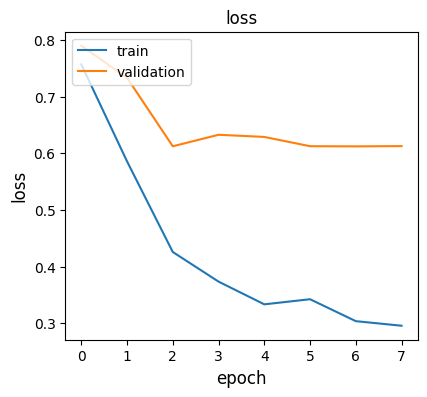

CV KL SCORE: 0.5598


In [24]:
if not SUBMISSION and not TEST_ENSEMBLE:
    reset_seed(42)
    all_oof = []
    all_true = []
    val_sizes = []
    losses = []
    val_losses = []
    total_hist = {}

    gkf = GroupKFold(n_splits=5)
    for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):
        print('#'*25)
        print(f'### Fold {i+1}')

        params = {'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
        data, val = train.iloc[train_index],train.iloc[valid_index]
        train_dataset = dataset(data, **params)
        val_dataset = dataset(val,mode='valid', **params)

        data = data[data['kl']<5.5]
        train_dataset2 = dataset(data, **params)
        train_size = get_size(train_index)
        valid_size = get_size(valid_index)
        print(f'### train size {train_size}, valid size {valid_size}')
        print('#'*25)
        model = build_model()
        hist = model.fit(train_dataset, validation_data = val_dataset,
                         epochs=5, callbacks=[LR])
        train_size = get_size(data)
        print(f'### seconds stage train size {train_size}, valid size {valid_size}')
        print('#'*25)
        hist2 = model.fit(train_dataset2, validation_data = val_dataset,
                         epochs=3, callbacks=[LR2])
        losses.append(hist.history['loss']+hist2.history['loss'])
        val_losses.append(hist.history['val_loss']+hist2.history['val_loss'])
        with strategy.scope():
            model.save_weights(f'/kaggle/output/hms-features-head-starter/model_{DATA_TYPE}_{MODEL[DATA_TYPE]}_{i}.weights.h5')
        params = {'mode':'valid','data':val,'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
        oof = predict(MODEL, params, i, models_path='./')
        all_oof.append(oof)
        all_true.append(train.iloc[valid_index][TARGETS].values)
        val_sizes.append(len(valid_index))
        del model, oof
        gc.collect()

    total_hist['loss'] = np.mean(losses,axis=0)
    total_hist['val_loss'] = np.mean(val_losses,axis=0)
    all_oof = np.concatenate(all_oof)
    all_true = np.concatenate(all_true)
    plot_hist(total_hist)
    print(f'CV KL SCORE: {score(all_true,all_oof):.4f}')

### Local Ensemble Testing on CV

In [26]:
if not SUBMISSION and TEST_ENSEMBLE:
    MODELS = {
          'K'     : 43, # 'LB':0.41 Kaggle's spectrogram model version
          'E'     : 42, # 'LB':0.39 EEG's spectrogram model version
          'R'     : 37, # 'LB':0.41 EEG's Raw wavenet model version, trained on single GPU
          'KE'    : 47, # 'LB':0.37 Kaggle's and EEG's spectrogram model version
          'KR'    : 48, # 'LB':0.39 Kaggle's spectrogram and Raw model version
          'ER'    : 49, # 'LB':0.38 EEG's spectrogram and Raw model version
          'KER'   : 50, # 'LB':0.36 EEG's, Kaggle's spectrograms and Raw model version
          'K+E'   : 51, # 'LB':0.37 Data spectrogram augmentation model version
          'K+E+KE': 52, # 'LB':0.36 Data spectrogram augmentation model version
         }
    reset_seed(42)
    gkf = GroupKFold(n_splits=5)
    all_oof = []
    all_true = []
    for i, (_, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):
        print(f'Fold {i+1}')
        val_data = train.iloc[valid_index].copy()
        params = {'mode':'valid','data':val_data,'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
        oof = predict(MODELS,params,i)
        all_oof.append(oof)
        all_true.append(val_data[TARGETS].values)

    all_oof = np.concatenate(all_oof)
    all_true = np.concatenate(all_true)
    print(f'CV KL SCORE: {score(all_true,all_oof):.4f}')

### Infer Test and Create Submission CSV
Infer the test data and create a `submission.csv` file.

In [ ]:
if SUBMISSION:
    test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
    print('Test shape',test.shape)
    test.head()

In [ ]:
# READ ALL SPECTROGRAMS
if SUBMISSION:
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms'
    files2 = os.listdir(PATH2)
    print(f'There are {len(files2)} test spectrogram parquets')

    spectrograms2 = {}
    for i,f in enumerate(files2):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH2}/{f}')
        name = int(f.split('.')[0])
        spectrograms2[name] = tmp.iloc[:,1:].values

    # RENAME FOR DATA GENERATOR
    test = test.rename({'spectrogram_id':'spec_id'},axis=1)

In [ ]:
# READ ALL EEG SPECTROGRAMS
if SUBMISSION:
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs'
    DISPLAY = 0
    EEG_IDS2 = test.eeg_id.unique()
    all_eegs2 = {}

    print('Converting Test EEG to Spectrograms...'); print()
    for i,eeg_id in enumerate(EEG_IDS2):

        # CREATE SPECTROGRAM FROM EEG PARQUET
        img = spectrogram_from_eeg(f'{PATH2}/{eeg_id}.parquet')
        all_eegs2[eeg_id] = img

In [ ]:
# READ ALL RAW EEG SIGNALS
if SUBMISSION :
    all_raw_eegs2 = {}
    EEG_IDS2 = test.eeg_id.unique()
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs'

    print('Processing Test EEG parquets...'); print()
    for i,eeg_id in enumerate(EEG_IDS2):

        # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
        data = eeg_from_parquet(f'{PATH2}/{eeg_id}.parquet')
        all_raw_eegs2[eeg_id] = data

In [ ]:
# Submission ON TEST
if SUBMISSION:
    preds = []
    params = {'data':test,'mode':'test','specs':spectrograms2, 'eeg_specs':all_eegs2, 'raw_eegs':all_raw_eegs2}
    models = MODELS if ENSEMBLE else MODEL
    for i in range(5):
        print(f'Fold {i+1}')
        pred = predict(models,params,i)
        preds.append(pred)

    pred = np.mean(preds,axis=0)
    print('Test preds shape',pred.shape)

In [ ]:
if SUBMISSION:
    sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
    sub[TARGETS] = pred
    sub.to_csv('submission.csv',index=False)
    print('Submissionn shape',sub.shape)
    print()
    print(sub.head().to_string())

In [ ]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
if SUBMISSION:
    print(sub.iloc[:,-6:].sum(axis=1).to_string())